In [15]:
import numpy as np

from Analysis_utils import *
from Plots import *
from scipy.interpolate import CubicSpline
from timebudget import timebudget
from multiprocessing import Pool

# 3D Embedding

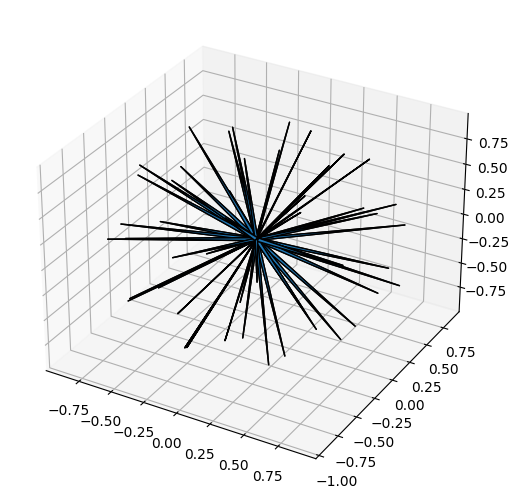

In [2]:
m = Manifold(100)
plot_triangulation_3d(m.adj)

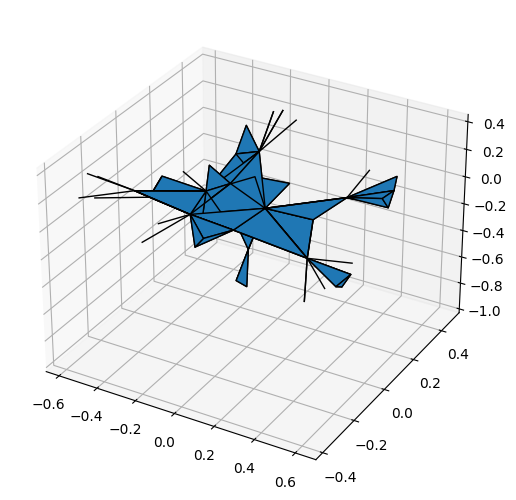

In [21]:
beta = 0.3
n_sweeps = 30
m.sweep(n_sweeps, beta, strategy=['gravity', 'spinor', 'scalar'])
plot_triangulation_3d(m.adj)

In [23]:
print("gravity:")
%time m.sweep(n_sweeps, beta, strategy=['gravity'])
print("\nspinors:")
%time m.sweep(n_sweeps, beta, strategy=['spinor'])
print("\ngravity + spinors:")
%time m.sweep(n_sweeps, beta, strategy=['gravity', 'spinor'])

gravity:
CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 145 ms

spinors:


/home/mgv29/Desktop/Internship 2022/Lattice Gravity/Euclifer/manifold_sampler/Triangulation.py:95: RuntimeWarning: overflow encountered in exp
  p = np.exp(-beta * (S_new - S_old))


CPU times: user 2.96 s, sys: 3.22 ms, total: 2.96 s
Wall time: 2.97 s

gravity + spinors:


/home/mgv29/Desktop/Internship 2022/Lattice Gravity/Euclifer/manifold_sampler/Triangulation.py:180: RuntimeWarning: overflow encountered in exp
  p = np.exp(-b * dS)


CPU times: user 5.28 s, sys: 0 ns, total: 5.28 s
Wall time: 5.28 s


In [7]:
A = m.A
psi = m.psi

j = 10
c = 4
adj_c = 20
theta = 1

def ex1():
    U = paral_trans(A[j])
    d_psi_0 = U[0, 0] * psi[adj_c, 0] + U[0, 1] * psi[adj_c, 1] - psi[c, 0]
    d_psi_1 = U[0, 0] * psi[adj_c, 1] + U[1, 1] * psi[adj_c, 1] - psi[c, 1]
    d_psi = np.array([d_psi_0, d_psi_1])
def ex2():
    d_psi = (np.matmul(paral_trans(A[j]), psi[adj_c]) - psi[c])

In [8]:
%timeit S_psi(m.adj, psi, c, A)
%timeit S_phi(m.adj, m.phi, c)

67.1 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
6.03 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
%timeit ex1()
%timeit ex2()

7 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
7.9 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
is_sphere_triangulation(m.adj)

True

# Distance Profile and Haussdorff Dimension (pure gravity)

20
28
40


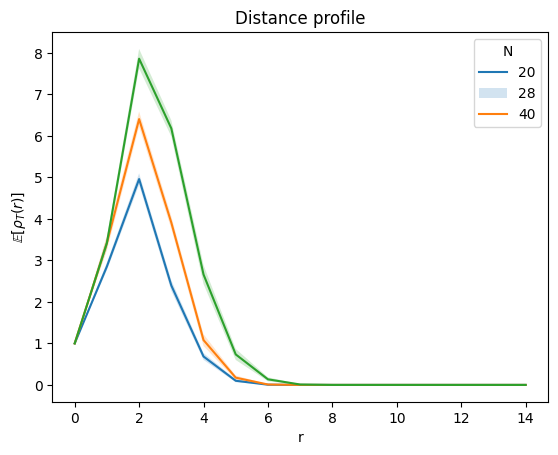

In [11]:
beta=0
sizes = np.array([2*int(i) for i in np.geomspace(10, 20, 3)])
profiles = make_profiles(beta, sizes, strategy=['gravity'])
plot_profiles(profiles, sizes)

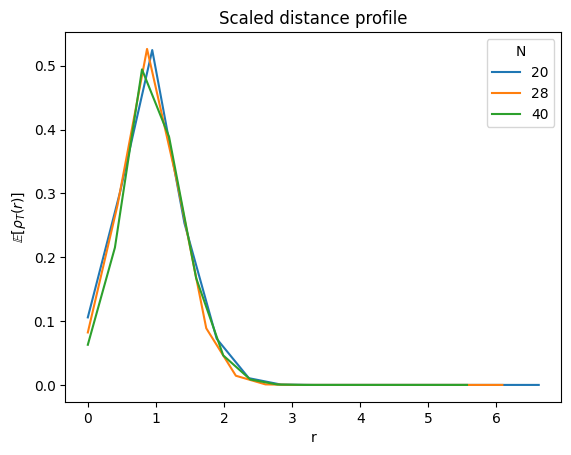

In [12]:
d_Haussdorf = 4
xs, ys = scale_profile(profiles, sizes, 1/d_Haussdorf)
overlay_profiles(ys, xs, sizes)

# Finite size scaling and Haussdorff Dimension

In [14]:
beta=0.5
sizes = [(int(i)//2)*2 for i in np.geomspace(30, 70, 4)]

prof = make_profiles(beta, sizes, meas_sweeps=2, strategy=['gravity', 'spinor'])


prof_0 = prof[..., 0]
rs0 = np.arange
rs = np.arange(0.1, 10, 0.05)
fit_prof = []


fig, ax = plt.subplots(1,2)



for profile in prof_0:
    dist_range = range(len(profile))
    cs = CubicSpline(dist_range, profile)
    fit_prof.append(cs(rs))
    ax[0].plot(dist_range, profile, 'x')

for p in fit_prof:
    ax[0].plot(rs, p)

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)
ax[1].plot(x, y, 'gx')

ax[0].set_title('Distance Profiles'), ax[1].set_title('$Log(r_{max})\; vs\; Log(dim)$')
ax[0].legend(["d = " + str(d) for d in sizes])
np.savez('data/profiles_spinor_1', full_prof=prof, fit_prof=np.array(fit_prof), prof_0=prof_0, sizes=sizes, beta=beta)

TypeError: make_profiles() got an unexpected keyword argument 'gravity_only'

In [ ]:
s = slice(0, None)
sizes = np.load('data/profiles_spinor_1.npz')['sizes'][s]
fit_prof = np.load('data/profiles_spinor_1.npz')['fit_prof'][s]
prof = np.load('data/profiles_spinor_1.npz')['full_prof'][s]

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)

fit = curve_fit(lin_fit, x, y, p0=[0.75, 0])
(d, a), err = fit
d_H = 1/(1-d)
d_err = np.sqrt(err[0,0])
d_H_err = d_H**2*d_err
a_err = np.sqrt(err[1,1])

print("\nwith spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

d_H, d_H_err, a, a_err = finite_size_scaling(prof, sizes)
print("\nwithout spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

In [ ]:
# CHECK ACCEPTANCE RATE OF ISING MOVES.
# RESCALE SPLINES SO THAT THEY HAVE SAME SIZE


steps = 50
n_plots = 4
fig, ax = plt.subplots(1,n_plots+1)

s = slice(0, None)
prof = np.load('data/profiles_spinor_1.npz')['full_prof'][s]

ds = np.linspace(3, 6, steps)
x_range = np.arange(0.5, 1.3, 0.05)
errors = []
min_err = np.inf
min_d = 0
for i, d in enumerate(ds):
    splines = []
    xs, ys = scale_profile(prof, sizes, 1/d)
    ys = ys[..., 0]
    for x, y in zip(xs, ys):
        cs = CubicSpline(x, y)
        splines.append(cs(x_range))

        interval = int(np.ceil(steps/n_plots))
        if i%interval==0:
            ax[i//interval].plot(x_range, cs(x_range))

    splines = np.array(splines)
    err_spline = np.sum(np.var(splines, axis=0))
    if err_spline < min_err:
        min_err = err_spline
        min_d = d
    errors.append(err_spline)


print(f'{min_d = }')
print(f'{min_err = }')
ax[-1].plot(ds, errors)

ax[0].set_title('hi')

In [ ]:
import multiprocessing as mp
print(mp.cpu_count())

In [ ]:
pool = mp.Pool(mp.cpu_count())

In [ ]:
a = np.random.normal(size=(4))
a

In [ ]:
def square(x):
    return [np.cos(x) for _ in range(int(1e13))]

In [ ]:
def run_s(op, input, pool):
    print("hi")
    return pool.map(op, input)

In [ ]:
%time (square(x) for x in a)
%time run_s(square, a, pool)

In [ ]:
run_s(square, a, pool)

In [ ]:
1e10